# Garmin Fenix 7S

<p align="left">
  <img src="https://res.garmin.com/transform/image/upload/b_rgb:FFFFFF,c_pad,dpr_2.0,f_auto,h_400,q_auto,w_400/c_pad,h_400,w_400/v1/Product_Images/en/products/010-02539-00/v/cf-xl?pgw=1" width="300"/>
</p>

A versatile watch that is capable of tracking your heart rate, steps, and other metrics, the [Garmin Fenix 7S](https://www.garmin.com/en-US/p/735542) is a watch that stores a treasure trove of health data that we will explore in this notebook.

We've used the Garmin Fenix 7S for a while now, and we'll show you how to extract its data, visualize data, and compute correlations and other statistical measures based on your data! While you will need a Garmin Fenix 7S to actually collect the data itself, the data *extraction* requires only an internet connection and your username and password.

If you want to know more about the Garmin Fenix 7S, see the [Wearipedia](https://www.wearipedia.com/wearables/garmin-fenix) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.

You can extract the parameters as below:

| Parameter Name                  | Input Parameter                  | Frequency          | Return Type |
|---------------------------------|----------------------------------|---------------------|-------------|
| Steps                           | "steps"                          | 1 Day (15 Mins)     | List        |
| Body Battery                    | "body_battery"                   | 1 Day               | List        |
| Heart Rate                      | "hr"                             | 1 Day               | List        |
| Blood Pressure                  | "blood_pressure"                 | Entire Period      | JSON        |
| Floors                          | "floors"                         | 1 Day (15 Mins)     | List        |
| Resting Heart Rate              | "rhr"                            | Entire Period (1 Day) | JSON      |
| Hydration                       | "hydration"                      | 1 Day               | List        |
| Sleep                           | "sleep"                          | 1 Day               | List        |
| Stress                          | "stress"                         | 1 Day               | List        |
| Respiration                     | "respiration"                    | 1 Day               | List        |
| SPO2                            | "spo2"                           | 1 Day               | List        |
| Heart Rate Variability          | "hrv"                            | 1 Day               | List        |


In this guide, we sequentially cover the following **nine** topics to extract from the unofficial Garmin API:
1. **Setup**
    - Data Receiver Setup
    - Participant Setup
    - We install the necessary packages and import them.
2. **Authentication/Authorization**
    - Requires only username and password.
3. **Data extraction**
    - We get data via `wearipedia` in a couple lines of code.
4. **Data Exporting**
    - We export all of this data to file formats compatible by R, Excel, and MatLab.
5. **Adherence**
    - We visualize when data was collected given start date and end date plotting a usage block plot.
6. **Visualization**
    - We create a basic plot to visualize our data.
7. **Advanced visualization**
    - 7.1:  We plot a calendar plot of usage / step counts over time
    - 7.2: We reproduce the plot of breath rate over a given day
7. **Outlier Detection and Data Cleaning**
    - We detect outliers in our data and filter them out.
8. **Data analysis**
    - 9.1: We try to find a correlation between heart rate and activity (number of steps)
    - 9.2: We try to find the correlation between heart rate and breaths per minute
    

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## 1.1 Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`, and a password.
2. [Create a Garmin Connect account](https://sso.garmin.com/portal/sso/en-GB/create-account?clientId=GarminConnect&service=https://connect.garmin.com/modern) with the email and the password.
3. Keep email and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter below.
5. Install the `wearipedia` Python package to easily extract data from this device via the Garmin Connect API.

## 1.2 Participant Setup

Dear Participant,

Once you unbox your Garmin Fenix 7S, please set up the device by following the resources below. When prompted to login to a Garmin Connect account, use the email and password provided by the research coordinator.

- Written guide: https://support.garmin.com/en-US/?faq=jvJTLgrDV881K1NXuC4CsA
- Video guide: https://www.youtube.com/watch?v=Fgq6LM2NqNo

Best,

Wearipedia



In [220]:
!pip install --no-cache-dir git+https://github.com/a-llison-lau/wearipedia.git

  Cloning https://github.com/a-llison-lau/wearipedia.git to /tmp/pip-req-build-s10lakio
  Running command git clone --filter=blob:none --quiet https://github.com/a-llison-lau/wearipedia.git /tmp/pip-req-build-s10lakio
  Resolved https://github.com/a-llison-lau/wearipedia.git to commit ce3dd384065089d75e84756acae1577fdcca9430
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 2. Authentication/Authorization

To obtain access to data, authorization is required. All you'll need to do here is just put in the email and password for the Garmin Fenix 7S device. We'll use this username and password to extract the data in the sections below.

In [221]:
#@title Enter Garmin login credentials
email_address = "jadongeathers@gmail.com" #@param {type:"string"}
password = "StanfordGarminD4ta" #@param {type:"string"}

# 3. Data Extraction

Data can be extracted via [wearipedia](https://github.com/Stanford-Health/wearipedia/), our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

In [222]:
#@title Enter start and end dates (in the format yyyy-mm-dd)

#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2022-03-01' #@param {type:"string"}
end_date='2022-06-17' #@param {type:"string"}
synthetic = True #@param {type:"boolean"}

In [223]:
import wearipedia
import pandas as pd
import numpy as np
from IPython.display import display
!pip install july
import matplotlib.pyplot as plt
import july

device = wearipedia.get_device("garmin/fenix_7s")

if not synthetic:
    device.authenticate({"email": email_address, "password": password})

params = {"start_date": start_date, "end_date": end_date}

In [224]:
#@title Extracting all datafields

steps = device.get_data("steps", params=params)
floors = device.get_data("floors", params=params)
stress = device.get_data("stress", params=params)
respiration = device.get_data("respiration", params=params)
body_battery = device.get_data("body_battery", params=params)
hr = device.get_data("hr", params=params)
blood_pressure = device.get_data("blood_pressure", params=params)
rhr = device.get_data("rhr", params=params)
hydration = device.get_data("hydration", params=params)
sleep = device.get_data("sleep", params=params)
spo2 = device.get_data("spo2", params=params)
hrv = device.get_data("hrv", params=params)

# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.)

Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [225]:
#@title Select which type of data to export as JSON

import json

get_steps = True # @param {type:"boolean"}
get_body_battery = True # @param {type:"boolean"}
get_hr = True # @param {type:"boolean"}
get_blood_pressure = True # @param {type:"boolean"}
get_floors = True # @param {type:"boolean"}
get_rhr = True # @param {type:"boolean"}
get_hydration = True # @param {type:"boolean"}
get_sleep = True # @param {type:"boolean"}
get_stress = True # @param {type:"boolean"}
get_respiration = True # @param {type:"boolean"}
get_spo2 = True # @param {type:"boolean"}
get_hrv = True # @param {type:"boolean"}


if get_steps:
    json.dump(steps, open("steps.json", "w"))
if get_body_battery:
    json.dump(body_battery, open("body_battery.json", "w"))
if get_hr:
    json.dump(hr, open("hr.json", "w"))
if get_blood_pressure:
    json.dump(blood_pressure, open("blood_pressure.json", "w"))
if get_floors:
    json.dump(floors, open("floors.json", "w"))
if get_rhr:
    json.dump(rhr, open("rhr.json", "w"))
if get_hydration:
    json.dump(hydration, open("hydration.json", "w"))
if get_sleep:
    json.dump(sleep, open("sleep.json", "w"))
if get_stress:
    json.dump(stress, open("stress.json", "w"))
if get_respiration:
    json.dump(respiration, open("respiration.json", "w"))
if get_spo2:
    json.dump(spo2, open("spo2.json", "w"))
if get_hrv:
    json.dump(hrv, open("hrv.json", "w"))

Feel free to open the file viewer (see left pane) to look at the outputs!

## Exporting to CSV and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to CSV/XLSX requires a bit more processing, since they enforce a pretty restrictive schema.

We will thus export steps, heart rates, and breath rates all as separate files.

In [226]:
#@title Select which type of data to export as CSV and XLSX

import pandas as pd

get_steps = True # @param {type:"boolean"}
get_body_battery = True # @param {type:"boolean"}
get_hr = True # @param {type:"boolean"}
get_blood_pressure = True # @param {type:"boolean"}
get_floors = True # @param {type:"boolean"}
get_rhr = True # @param {type:"boolean"}
get_hydration = True # @param {type:"boolean"}
get_sleep = True # @param {type:"boolean"}
get_stress = True # @param {type:"boolean"}
get_respiration = True # @param {type:"boolean"}
get_spo2 = True # @param {type:"boolean"}
get_hrv = True # @param {type:"boolean"}


# Steps
if get_steps:
    df = pd.DataFrame(steps)
    df.to_csv('steps.csv', index=False)
    df.to_excel('steps.xlsx', index=False)


# Body Battery
if get_body_battery:
    df = pd.DataFrame(body_battery)
    df.to_csv('body_battery.csv', index=False)
    df.to_excel('body_battery.xlsx', index=False)

# HR
if get_hr:
    df = pd.DataFrame(hr)
    df.to_csv('hr.csv', index=False)
    df.to_excel('hr.xlsx', index=False)

# Blood Pressure
if get_blood_pressure:
    df = pd.DataFrame([blood_pressure])
    df.to_csv('blood_pressure.csv', index=False)
    df.to_excel('blood_pressure.xlsx', index=False)

# Floors
if get_floors:
    df = pd.DataFrame(floors)
    df.to_csv('floors.csv', index=False)
    df.to_excel('floors.xlsx', index=False)

# RHR
if get_rhr:
    df = pd.DataFrame([rhr])
    df.to_csv('rhr.csv', index=False)
    df.to_excel('rhr.xlsx', index=False)

# Hydration
if get_hydration:
    df = pd.DataFrame(hydration)
    df.to_csv('hydration.csv', index=False)
    df.to_excel('hydration.xlsx', index=False)

# Sleep
if get_sleep:
    df = pd.DataFrame(sleep)
    df.to_csv('sleep.csv', index=False)
    df.to_excel('sleep.xlsx', index=False)

# Stress
if get_stress:
    df = pd.DataFrame(stress)
    df.to_csv('stress.csv', index=False)
    df.to_excel('stress.xlsx', index=False)

# Respiration
if get_respiration:
    df = pd.DataFrame(respiration)
    df.to_csv('respiration.csv', index=False)
    df.to_excel('respiration.xlsx', index=False)

# Spo2
if get_spo2:
    df = pd.DataFrame(spo2)
    df.to_csv('spo2.csv', index=False)
    df.to_excel('spo2.xlsx', index=False)

# HRV
if get_hrv:
    df = pd.DataFrame(hrv)
    df.to_csv('hrv.csv', index=False)
    df.to_excel('hrv.xlsx', index=False)


# 5. Adherence

We are interested in knowing on which days our user used the watch. We can plot a graph to visualize this.

To simulate potential nonadherence, we randomly remove a portion of the recorded heart rate entries from the dataset. This mimics scenarios where individuals may forget to wear their watch or intentionally choose not to use it on certain days.

In this example, we have heart rate data recorded for every day between the specified start date and end date. We randomly select a percentage of recorded heart rate entries to remove. We create a binary indicator for each day within the specified date range, where a value of 1 indicates that heart rate data is recorded for that day, and a value of 0 indicates no recorded heart rate data.

Finally, we visualize the presence of recorded heart rate data over the specified date range using a step plot. This plot highlights the simulated nonadherence by illustrating gaps in the recorded heart rate data on certain days.

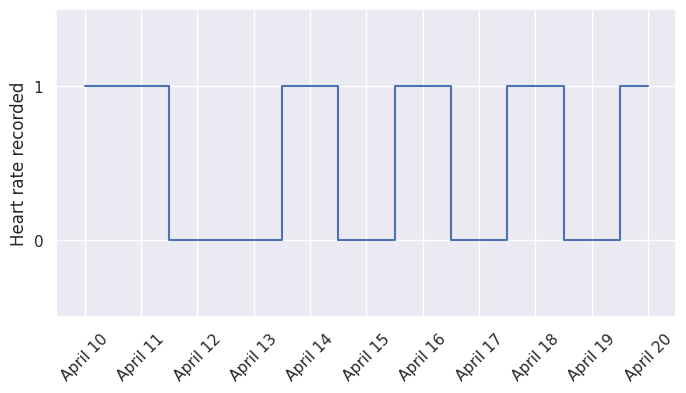

In [227]:
#@title Select dates to check user adherence

start_date = "2022-04-10" #@param {type:"date"}
end_date = "2022-04-20" #@param {type:"date"}
hr_df = pd.DataFrame(hr)

date_range = pd.date_range(start=start_date, end=end_date)
hr_dates = pd.to_datetime(hr_df["calendarDate"]).dt.date
hr_dates = hr_dates[::-1]

# Remove 40% of the data randomly
np.random.seed(44)
percentage_to_remove = 0.4
num_entries_to_remove = int(len(hr_dates) * percentage_to_remove)
indices_to_remove = hr_dates.sample(num_entries_to_remove).index
hr_dates_cleaned = hr_dates.drop(indices_to_remove)

presence = [1 if pd.Timestamp(date).date() in hr_dates_cleaned.values else 0 for date in date_range]
plt.figure(figsize=(8, 4))
plt.style.use('fast')
plt.step(date_range, presence, where='mid')
plt.ylabel('Heart rate recorded')
plt.ylim(bottom=-0.5, top=1.5)
plt.yticks([0, 1])
formatted_dates = [date.strftime('%B %d') for date in date_range]
plt.xticks(date_range, formatted_dates)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our all kinds of data in a plot. This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

In [228]:
from datetime import datetime, timedelta
from logging import exception
#@title Select data to plot { display-mode: "form" }

feature = "steps" #@param ["steps", "body_battery", "hr", "floors", "stress"]
visual_start_date = "2022-03-04" #@param {type:"date"}
# visual_end_date = "2022-04-04" #@param {type: "date"}
time_interval = "One Day" #@param ["One Day", "One Week (7 Days)", "One Month (30 Days)", "One Year (365 Days)", "Entire Time Period"]
smooth_plot = True #@param {type:"boolean"}

# Valid Interval Check
dates = device.get_data("dates", params=params)
str_visual_start_date = visual_start_date
visual_start_date = datetime.strptime(visual_start_date, '%Y-%m-%d')
if visual_start_date + timedelta(days=365) > dates[-1] and time_interval == "One Year (365 Days)":
  raise Exception("Not enough data. Please select appropriate time interval.")
elif visual_start_date + timedelta(days=30) > dates[-1] and time_interval == "One Month (30 Days)":
  raise Exception("Not enough data. Please select appropriate time interval.")
elif visual_start_date + timedelta(days=7) > dates[-1] and time_interval == "One Week (7 Days)":
  raise Exception("Not enough data. Please select appropriate time interval.")
elif visual_start_date + timedelta(days=1) > dates[-1] and time_interval == "One Day":
  raise Exception("Not enough data!")

start_date_index = dates.index(visual_start_date)
print()
print(f"Start date: {dates[start_date_index]}")
if time_interval == "One Day":
    end_date_index = dates.index(visual_start_date + timedelta(days=1))
elif time_interval == "One Week (7 Days)":
    end_date_index = dates.index(visual_start_date + timedelta(days=7))
elif time_interval == "One Month (30 Days)":
    end_date_index = dates.index(visual_start_date + timedelta(days=30))
elif time_interval == "One Year (365 Days)":
    end_date_index = dates.index(visual_start_date + timedelta(days=365))
elif time_interval == "Entire Time Period":
    end_date_index = len(dates) - 1

print(f"End date: {dates[end_date_index]}")



Start date: 2022-03-04 00:00:00
End date: 2022-03-05 00:00:00


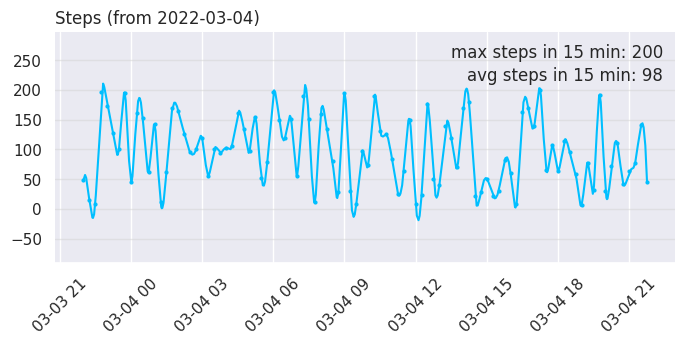

In [229]:
#@title Plot Visualization
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

if feature == "steps":
    steps = device.get_data("steps", params=params)
    steps_data = steps[start_date_index:end_date_index]
    steps_df_list = []
    for i in range(len(steps_data)):
      steps_temp_df = pd.DataFrame(steps_data[i])
      steps_df_list.append(steps_temp_df)
    df = pd.concat(steps_df_list)

    df['startGMT'] = pd.to_datetime(df['startGMT'])
    fig, ax = plt.subplots(figsize=(8, 3))
    start_time = df['startGMT']
    steps = df['steps']
    x_timestamps = np.array([dt.timestamp() for dt in start_time])
    interp_func = interp1d(x_timestamps, steps, kind='cubic')
    new_x_timestamps = np.linspace(min(x_timestamps), max(x_timestamps), num=1000)
    new_x = np.array([datetime.fromtimestamp(ts) for ts in new_x_timestamps])
    new_y = interp_func(new_x_timestamps)
    plt.scatter(start_time, steps, s=4, c='deepskyblue')
    if smooth_plot:
      plt.plot(new_x, new_y, color='deepskyblue')
    else:
      plt.plot(start_time, steps, color='deepskyblue')
    plt.title(f'Steps (from {str_visual_start_date})', loc='left')
    plt.xticks(rotation=45)
    # plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H'))

    mean_steps = df['steps'].mean()
    max_steps = df['steps'].max()
    min_steps = df['steps'].min()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.grid(True, color='lightgrey', alpha=0.5)

    plt.ylim(min_steps - mean_steps, max_steps + mean_steps)
    plt.text(0.98, 0.95, f'max steps in 15 min: {max_steps}', ha='right', va='top', transform=ax.transAxes)
    plt.text(0.98, 0.85, f'avg steps in 15 min: {mean_steps:.0f}', ha='right', va='top', transform=ax.transAxes)
    plt.style.use('default')
    plt.show()

elif feature == "body_battery":
    body_battery = device.get_data("body_battery", params=params)
    body_battery_data = body_battery[start_date_index:end_date_index]
    body_battery_data = np.array(body_battery_data)
    body_battery_data = body_battery_data.flatten()
    body_battery_data = body_battery_data.tolist()
    df = pd.DataFrame(body_battery_data)
    battery_value = df['bodyBatteryValuesArray']
    concatenated_data = []
    for row in battery_value:
        concatenated_data.extend(row)
    concatenated_data = np.array(concatenated_data)
    time = concatenated_data[:, 0]
    time = pd.to_datetime(time, unit='ms')
    battery = concatenated_data[:, 1]

    fig, ax = plt.subplots(figsize=(8, 3))
    plt.style.use('default')
    x_timestamps = np.array([dt.timestamp() for dt in time])
    interp_func = interp1d(x_timestamps, battery, kind='cubic')
    new_x_timestamps = np.linspace(min(x_timestamps), max(x_timestamps), num=1000)
    new_x = np.array([datetime.fromtimestamp(ts) for ts in new_x_timestamps])
    new_y = interp_func(new_x_timestamps)
    plt.scatter(time, battery, s=4, c='deepskyblue')

    if smooth_plot:
      plt.plot(new_x, new_y, color='deepskyblue')
    else:
      plt.plot(time, battery, color='deepskyblue')

    # Title
    plt.title(f'Battery (from {str_visual_start_date})', loc='left')
    plt.xticks(rotation=45)

    # Set gridlines
    ax.yaxis.grid(True, color='lightgrey', alpha=0.5)

    # Hide spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.show()

elif feature == "hr":
    hr_data = hr[start_date_index:end_date_index]
    df = pd.DataFrame(hr_data)
    resting = df['restingHeartRate']
    continuous_hr = df['heartRateValues']
    concatenated_data = []
    for row in continuous_hr:
        concatenated_data.extend(row)
    concatenated_data = np.array(concatenated_data)
    time = concatenated_data[:, 0]
    time = pd.to_datetime(time, unit='ms')
    continuous_hr = concatenated_data[:, 1]
    max_hr = np.max(continuous_hr)
    avg_resting = np.mean(resting)

    fig, ax = plt.subplots(figsize=(8, 3))
    plt.style.use('default')

    x_timestamps = np.array([t.timestamp() for t in time])
    interp_func = interp1d(x_timestamps, continuous_hr, kind='cubic')
    new_x_timestamps = np.linspace(min(x_timestamps), max(x_timestamps), num=1000)
    new_x = np.array([datetime.fromtimestamp(ts) for ts in new_x_timestamps])
    new_y = interp_func(new_x_timestamps)
    plt.scatter(time, continuous_hr, s=4, c='deepskyblue')

    if smooth_plot:
      plt.plot(new_x, new_y, color='deepskyblue')
    else:
      plt.plot(time, continuous_hr, color='deepskyblue')

    max_hr = np.max(continuous_hr)
    plt.title(f'Heart rate (from {str_visual_start_date})', loc='left')
    plt.xticks(rotation=45)

    ax.yaxis.grid(True, color='lightgrey', alpha=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.text(0.98, 0.95, f'max heart rate: {max_hr} bpm', ha='right', va='top', transform=ax.transAxes)
    plt.show()

elif feature == "floors":
    floor_data = floors[start_date_index:end_date_index]
    df = pd.DataFrame(floor_data)
    floor_values = df['floorValuesArray']
    concatenated_data = []
    for row in floor_values:
        concatenated_data.extend(row)
    concatenated_data = np.array(concatenated_data)
    df = pd.DataFrame(concatenated_data, columns=['time', 'end_time', 'ascended', 'descended'])

    # Delete the second column (ascended)
    df.drop(columns=['end_time'], inplace=True)

    # Rename the columns
    df.columns = ['time', 'ascended', 'descended']
    df['ascended'] = pd.to_numeric(df['ascended'])
    df['descended'] = pd.to_numeric(df['descended'])

    # Convert 'time' column to datetime
    df['time'] = pd.to_datetime(df['time'])
    df['time'] = df['time'].dt.date

    grouped_df = df.groupby('time').sum().reset_index()
    fig, ax = plt.subplots()

    plt.bar(grouped_df['time'], grouped_df['ascended'], color='green', alpha=0.5, label='Ascended', edgecolor='none')
    plt.bar(grouped_df['time'], grouped_df['descended'], color='red', alpha=0.5, label='Descended', edgecolor='none')


    ax.yaxis.grid(True, color='lightgrey', alpha=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.title(f'Floors (from {str_visual_start_date})', loc='left')
    plt.xticks(grouped_df['time'], rotation=45)
    plt.legend()
    plt.show()
elif feature == "stress":
    stress = device.get_data("stress", params=params)
    stress_data = stress[start_date_index:end_date_index]
    df = pd.DataFrame(stress_data)
    stress_values = df['stressValuesArray']
    concatenated_data = []
    for row in stress_values:
        concatenated_data.extend(row)
    concatenated_data = np.array(concatenated_data)
    time = concatenated_data[:, 0]
    time = pd.to_datetime(time, unit='ms')
    stress = concatenated_data[:, 1]
    max_stress = np.max(stress)
    avg_stress = np.mean(stress)

    fig, ax = plt.subplots(figsize=(10, 3))
    plt.style.use('default')

    x_timestamps = np.array([t.timestamp() for t in time])
    interp_func = interp1d(x_timestamps, stress, kind='cubic')
    new_x_timestamps = np.linspace(min(x_timestamps), max(x_timestamps), num=1000)
    new_x = np.array([datetime.fromtimestamp(ts) for ts in new_x_timestamps])
    new_y = interp_func(new_x_timestamps)
    plt.scatter(time, stress, s=4, c='deepskyblue')

    if smooth_plot:
      plt.plot(new_x, new_y, color='deepskyblue')
    else:
      plt.plot(time, stress, color='deepskyblue')

    # Adjust gridlines
    ax.yaxis.grid(True, color='lightgrey', alpha=0.5)

    # Hide spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.ylim(top=max_stress + 10)

    plt.title(f'Stress (from {str_visual_start_date})')
    plt.xticks(rotation=45)
    plt.text(0.98, 0.95, f'max stress: {max_stress}', ha='right', va='top', transform=ax.transAxes)
    plt.text(0.98, 0.85, f'avg stress: {avg_stress:.0f}', ha='right', va='top', transform=ax.transAxes)
    plt.show()

# 7. Advanced Visualization

Now we'll do some more advanced plotting that at times features hardcore matplotlib hacking with the benefit of aesthetic quality.

Note that the timestamps that were extracted above correspond to days demarcated by midnight *not necessarily in UTC*, but rather where the user lives. To be precise, the timestamps themselves are in UTC, but the day element they belong to is determined by their location of residence.

## 7.1. Calendar plot of usage / step counts over time

First, it's important to know when the user has been wearing the device. That way, we know the high-level time frame for the measurements, and can know where to focus analysis on.

To figure this out, we'll make a calendar plot. Fortunately, this idea is easy to execute with the use of [`july`](https://github.com/e-hulten/july/), a custom library that allows us to create beautiful calendar plots. We'll interpret step count as a proxy for usage and plot colors accordingly.

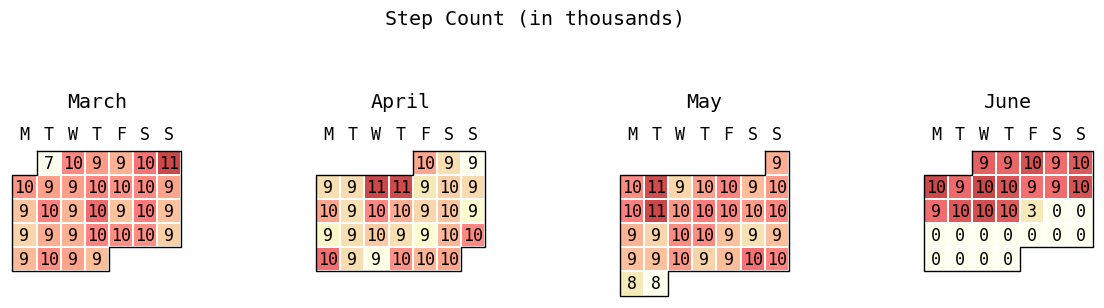

In [230]:
steps = device.get_data("steps", params=params)
steps_df_list = []
for i in range(len(steps)):
  steps_temp_df = pd.DataFrame(steps[i])
  steps_df_list.append(steps_temp_df)
df = pd.concat(steps_df_list)
df['startGMT'] = pd.to_datetime(df['startGMT'])
daily_steps = df.groupby(df['startGMT'].dt.date)['steps'].sum()
july.calendar_plot(daily_steps.index, daily_steps.values / 1000, value_label=True, weeknum_label=False, title=False)
plt.suptitle('Step Count (in thousands)', y=1.03)
plt.show()

This plot is very important because we are able to gain a high-level overview of the usage patterns, which informs all further analysis. If we discover that the participant has not worn their watch at all or has stopped wearing it for an extended period of time, then this is crucial information for figuring out why downstream analyses may be returning unexpected results.

## 7.2. Breath rate over a given day

Next, we will reproduce the below plot that you can see in the Garmin Connect webapp.

<img src="https://i.imgur.com/wpO1dBy.png" width=800></img>

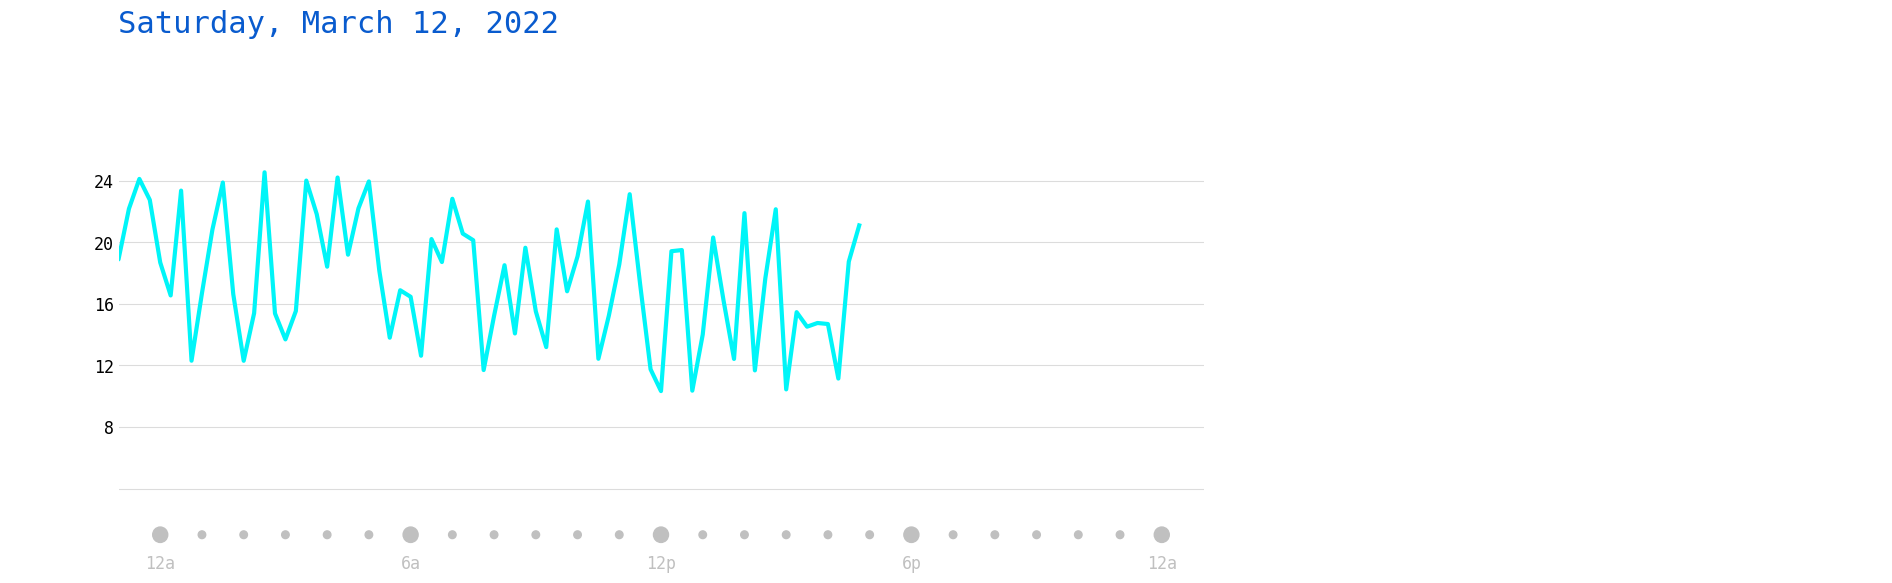

In [231]:
# get rid of any garbage output
# https://stackoverflow.com/questions/56727370/how-to-suppress-output-in-google-colaboratory-cell-which-executes-a-command-line
#%%capture

#@title Choose a date to visualize (timezone is where the data was *collected*)
date_to_visualize = "2022-03-12" #@param {type:"date"}
timezone_name = "US/Pacific" #@param {type:"string"}

import warnings
warnings.filterwarnings("ignore")

# restore rcParams
# plt.rcParams.update(IPython_default)


# fetch the right day for heart rate
from datetime import datetime
idx = np.where(np.array([datetime.strftime(d, '%Y-%m-%d') for d in dates]) == date_to_visualize)[0][0]

heart_rate_day = np.array(hr[idx]['heartRateValues'])

heart_rate_day = np.array(respiration[idx]['respirationValuesArray'])

steps_day = steps[idx]

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import matplotlib.dates as mdates
import matplotlib.ticker
import matplotlib.patches as patches
from scipy.interpolate import make_interp_spline
from dateutil import parser

from PIL import Image
import io
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import clear_output

matplotlib.rcParams['timezone'] = timezone_name

# change the background to the same grey
plt.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(14,6))

start = parser.parse(date_to_visualize + ' 00:00:00-07:00')

heart_rate_day = np.concatenate([
    [[int(start.timestamp() * 1000), None]],
    heart_rate_day
])


datetimes = [datetime.fromtimestamp(x // 1000) for x in heart_rate_day[:,0]]

datetimes_num = [mdates.date2num(x) for x in datetimes]

heart_rate_day_imputed = [x for x in heart_rate_day[:,1]]

heart_rate_day_imputed = [None] + heart_rate_day_imputed

for i, x in enumerate(heart_rate_day_imputed):
    if x is None:
        heart_rate_day_imputed[i] = 0

heart_rate_day_imputed = np.array(heart_rate_day_imputed)

# get the contiguous regions in heart_rate_day to plot
# these separately
empty_idxes = np.where(heart_rate_day_imputed[1:] >= 0)[0]

regions = []

cur_region_start = -1

cur_region_end = -1

for idx1, idx2 in zip(empty_idxes[:-1], empty_idxes[1:]):
    if cur_region_start == -1:
        cur_region_start = idx1
        cur_region_end = idx2

    if idx2 - idx1 > 1:
        cur_region_end = idx1
        # add 1 to account for extra dummy entry in heart_rate_day
        # at the beginning
        regions.append((cur_region_start+1, cur_region_end+1))

        cur_region_start = -1
        cur_region_end = -1
else:
    # special condition for last region
    regions.append((cur_region_start+1, empty_idxes.shape[0]))

for region_start, region_end in regions:
    plt.plot(datetimes_num[region_start:region_end],
             heart_rate_day[region_start:region_end],
             linewidth=3, color='#00f5f8')

ax = plt.gca()

steps_day_vals = np.array([x['steps'] for x in steps_day])

# smooth out and plot out on a minute basis
df = pd.DataFrame(columns=['datetime', 'steps_scaled'])

df.datetime = [parser.parse(x['startGMT']) for x in steps_day]
df.steps_scaled = steps_day_vals / 8 + 20

index_minutely = pd.date_range(df.datetime.iloc[0], df.datetime.iloc[-1], freq='1T')
spl = make_interp_spline(df.datetime, df.steps_scaled, k=3)
y_smooth = spl(index_minutely)

y_smooth = np.clip(y_smooth, 20, np.inf)

# plt.fill_between(index_minutely, y_smooth, 20, edgecolor='#aeeaff', facecolor='#d8f5ff', linewidth=1)

start = mdates.date2num(parser.parse(date_to_visualize + ' 00:00:00-07:00'))
end = mdates.date2num(parser.parse(date_to_visualize + ' 00:00:00-07:00') + timedelta(days=1))

# phantom rectangle to create space above the plot title
fig.patches.extend([patches.Rectangle((66.5, 400),
                                      100, 60, facecolor='white', zorder=-999999)])

# phantom rectangle to deal with the fact that the rectangle written
# just below creates a huge area of space to the left, so we equalize
# on the right with a phantom rectangle
#fig.patches.extend([patches.Rectangle((66.5, 10),
#                                      900, 50, facecolor='#f2f2f2', zorder=-999999)])

# rectangle to extend white background of the axis down further
# so that the ticks are not cut off
#fig.patches.extend([patches.Rectangle((66.5, 10),
#                                      781.5, 50, facecolor='white', zorder=-999999)])

plt.xticks(ticks=np.linspace(start, end, 5), labels=['12a', '6a', '12p', '6p', '12a'])

plt.tick_params(
    axis='x',
    which='both',
    labelsize=12,
    labelcolor='silver',
    width=0  # set width to zero so that the ticks themselves are invisible
)

# just don't have any y ticks
plt.yticks(ticks=[4,8,12,16,20,24], labels=['','8','12','16','20','24'])
plt.tick_params(
    axis='y',
    which='both',
    color='gainsboro',
    labelsize=12
)
#ax.set_yticks(ticks=[])
#ax.set_yticklabels([])

TICKYPOS = 1

for tick_x in np.linspace(start, end, 5):
    r = 10
    # for some reason, width should be .001x of the height for it
    # to be a circle

    #ax.add_patch(patches.Rectangle((tick_x, TICKYPOS), 10, 10, linewidth=1, edgecolor='black', facecolor='black'))

    ax.add_patch(patches.Ellipse((tick_x,TICKYPOS), .0015 * r, .1 * r,
                                fill=True,clip_on=False, color='silver'))


# pseudo-minor ticks
for tick_x in np.linspace(start, end, 5 * 5):
    r = 5
    # for some reason, width should be .001x of the height for it
    # to be a circle

    ax.add_patch(patches.Ellipse((tick_x,TICKYPOS), .0015 * r, .1 * r,
                                fill=True,clip_on=False, color='silver'))


# hide the borders of the box (https://stackoverflow.com/questions/9750699/how-to-display-only-a-left-and-bottom-box-border-in-matplotlib)
for side in ['left', 'right', 'top', 'bottom']:
    ax.spines[side].set_visible(False)

plt.xlim(datetimes[0] - timedelta(hours=1),
         datetimes[0] + timedelta(days=1) + timedelta(hours=1))

date_to_visualize_fmted = datetime.strftime(datetime.strptime(date_to_visualize, '%Y-%m-%d'), '%A, %B %-d, %Y')

plt.title(f'{date_to_visualize_fmted}' + ' ' * 72, loc='left',
          fontsize=22, color='#095bce', pad=40)#, bbox={'facecolor':'white', 'edgecolor': 'white', 'alpha':1.0, 'pad':4})

ax.set_ylim(0, 30)

#plt.grid()
#ax.yaxis.grid(which="major", color='r', linestyle='-', linewidth=2, zorder=999999999999)
#ax.grid(b=True, which='major', color='b', linestyle='-')
plt.grid(color='gainsboro', which='major', axis='y', linestyle='solid')

#ax.xaxis.grid()
#ax.grid(True)
#ax.grid(axis='x', zorder=0)

plt.show()

Our visualization isn't exactly like the one on Garmin Connect webapp, and that is because our extracted data (provided by the API), only gives us the breath rate every 15 minutes. That is why our plot looks much less dense.

# 8. Outlier Detection and Data Cleaning

In this section, we will detect outliers in our extracted data and impute them.

Since there are currently no outliers (by construction, since it is simulated to have none), we will manually inject a couple.

In [232]:
hr_data = hr[start_date_index:end_date_index]
df = pd.DataFrame(hr_data)
resting = df['restingHeartRate']
continuous_hr = df['heartRateValues']
concatenated_data = []
for row in continuous_hr:
    concatenated_data.extend(row)
concatenated_data = np.array(concatenated_data)
time = concatenated_data[:, 0]
time = pd.to_datetime(time, unit='ms')
continuous_hr = concatenated_data[:, 1]

# Injecting an anomaly
concatenated_data[10][1] = 5

To identify outliers in our data, we'll use z-scores, which measure how far a data point deviates from the mean in terms of standard deviations, and is given by this formula:

$$
Z = \frac{\text{data point} - \text{mean of data set}}{\text{standard deviation}}
$$

This helps us gauge the likelihood of a data point being real. By setting a `threshold` value, we can define what constitutes an outlier. For instance, if a data point's z-score exceeds this threshold, it's likely an outlier. To calculate zscore, we can use `zscore` from `scipy.stats`.

**Step 1**: we calculate the z-scores for each data point in the average heart rate column. We then define a threshold value to determine outliers based on the absolute z-scores. Any data point with an absolute z-score greater than the threshold is considered an outlier.


In [233]:
from scipy.stats import zscore

# Calculate z-scores
z_scores = zscore(concatenated_data[:, 1])

threshold = 3 #@param {type:"number"}

outlier_indices = np.where(np.abs(z_scores) > threshold)[0]

**Step 2**: We replace the outlier datapoint by averaging around it.

In [234]:
old_data = []
old_time_idx = []
new_data = []
for idx in outlier_indices:
    mean_val = np.mean(concatenated_data[max(0, idx - 5):min(idx + 5, len(concatenated_data)), 1])
    old_data_i = concatenated_data[idx][1]
    old_data.append(old_data_i)
    old_time_idx.append(concatenated_data[idx][0])
    concatenated_data[idx][1] = mean_val
    new_data.append(mean_val)

    print(f'Replacing {concatenated_data[idx][0], old_data_i} with {mean_val}, obtained by averaging around it')
    print(f'Index in concatenated_data is {idx}')

old_time_idx = pd.to_datetime(old_time_idx, unit='ms')

Replacing (1646413200000, 5) with 74.1, obtained by averaging around it
Index in concatenated_data is 10


**Step 3**: We visualize the outlier and the data we have cleaned.

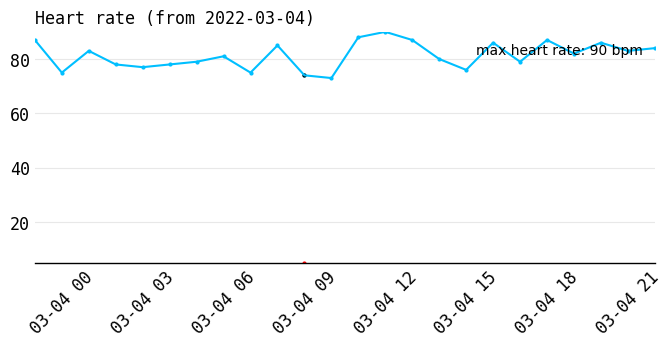

In [235]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.style.use('default')

plt.scatter(time, concatenated_data[:, 1], s=4, c='deepskyblue')
plt.plot(time, concatenated_data[:, 1], color='deepskyblue')
plt.scatter(old_time_idx, old_data, s=4, color='red', label='anomaly')
plt.scatter(old_time_idx, new_data, s=4, color='black', label='replacement')

max_hr = np.max(concatenated_data[:, 1])
plt.title(f'Heart rate (from {str_visual_start_date})', loc='left')
plt.xticks(rotation=45)

ax.yaxis.grid(True, color='lightgrey', alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.text(0.98, 0.95, f'max heart rate: {max_hr} bpm', ha='right', va='top', transform=ax.transAxes)
plt.show()

# 9. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section.

DISCLAIMER: We do not use the analyses below as evidence supporting any scientific claims. These analyses are purely intended for educational purposes.

## 9.1. Heart rate vs. activity

This first mini investigation will be to see if heart rate does increase when more steps are taken (and thus there is more activity). To be more specific, we would like to test the hypothesis that a higher step count is associated with a higher heart rate.

First, to get an intuitive understanding of the data, we can aggregate all of the datapoints and show a scatterplot of heart rates and step counts. This will take a bit of data manipulation, as step measurements are sampled only every 15 minutes, whereas heart rate measurements are taken every hour.

**Step 1**: We first extract the heart rate values from our heart rate dataframe. We create a new dataframe which contains two columns, the hour in the day, and the heart rate value recorded for this hour.

In [236]:
df = pd.DataFrame(hr)
continuous_hr = df['heartRateValues']
concatenated_data = []
for row in continuous_hr:
    concatenated_data.extend(row)
concatenated_data = np.array(concatenated_data)
hr_df = pd.DataFrame(concatenated_data, columns=['timestamp', 'value'])
hr_df['timestamp'] = pd.to_datetime(hr_df['timestamp'], unit='ms')

**Step 2**: We organize the steps data from our steps dataframe. Since the number of steps is recorded every 15 minutes, in order to match with our heart rate data, we will need to add up the step count in the 4 15-minute intervals in the hour.

In [237]:
steps_df_list = []
for i in range(len(steps)):
  steps_temp_df = pd.DataFrame(steps[i])
  steps_df_list.append(steps_temp_df)
steps_df = pd.concat(steps_df_list)
steps_df = steps_df[['startGMT', 'steps']]
steps_df['startGMT'] = pd.to_datetime(steps_df['startGMT'])
steps_by_hour = steps_df.groupby(steps_df['startGMT'].dt.floor('H'))['steps'].sum().reset_index()

**Step 3**: We will merge our organized heart rate dataframe and steps dataframe together to make our plotting more convenient.

In [238]:
hr_df['timestamp'] = pd.to_datetime(hr_df['timestamp'])
steps_by_hour['startGMT'] = pd.to_datetime(steps_by_hour['startGMT'])

merged_df = pd.merge_asof(hr_df, steps_by_hour, left_on='timestamp', right_on='startGMT')

merged_df.drop(columns=['startGMT'], inplace=True)
merged_df.rename(columns={'value': 'heart_rate'}, inplace=True)

**Step 4**: Finally, we plot a scatter plot of heart rate and step count. `sns.jointplot` allows us to visualize the distribution in the 2D space and also the distribution for each variable.

Text(32.0, 0.5, 'Heart rate')

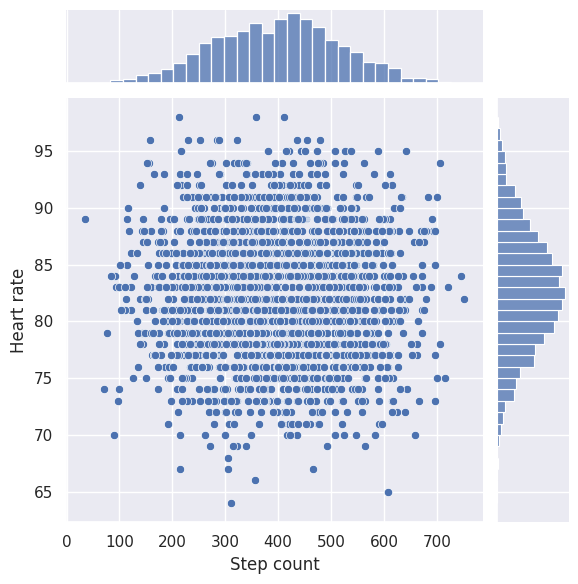

In [239]:
import seaborn as sns

sns.set()
sns.jointplot(x='steps', y='heart_rate', data=merged_df)
plt.xlabel('Step count')
plt.ylabel('Heart rate')

**Step 5**: Although we don't see an obvious trend here, we demonstrate the Wald test which can provide strong quantitative evidence to correlation between two variables.

In [240]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['steps'], merged_df['heart_rate'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -0.000806
Coefficient of determination: 0.000336
p-value: 0.351


Here, the slope indicates for every unit increase in the independent variable, the dependent variable increases or decreases by how many units. The coefficient of determination represents the percentage of the variance in the dependent variable that can explained by the independent variable. The p-value is the probability of observing a correlation as strong as the observed one in the sample, assuming there is no correlation in the population. A p-value that is less than 5% indicated statistical evidence.

In this investigation, it looks like there isn't much correlation between step count and heart rate.

## 9.2. Heart rate vs. breaths per minute

We may also be interested in understanding the relationship between the number of breaths the user takes per minute and the corresponding heart rate. In this situation, we would probably expect higher heart rates to be associated with a higher breath rate.

**Step 1**: We first organize the respiration data. The respiration value is collected every 15 minutes. But since our heart rate data is collected every hour, we take the mean of the breath rate in the 1-hour interval.

In [241]:
df = pd.DataFrame(respiration)
res_column = df['respirationValuesArray']

res_list = []
for i in range(len(res_column)):
  res_temp_df = pd.DataFrame(res_column[i])
  res_list.append(res_temp_df)
res_df = pd.concat(res_list)
res_df[0] = pd.to_datetime(res_df[0], unit='ms')
res_df.columns = ['time', 'breath_rate']
res_df['time'] = pd.to_datetime(res_df['time'])
res_by_hour = res_df.groupby(res_df['time'].dt.floor('H'))['breath_rate'].mean().reset_index()

**Step 2**: We merge the respiration dataframe we just organized with the heart rate data. We use the heart rate dataframe which we have already organized in section 9.1.

In [242]:
hr_df['timestamp'] = pd.to_datetime(hr_df['timestamp'])
res_by_hour['time'] = pd.to_datetime(res_by_hour['time'])

merged_df = pd.merge_asof(hr_df, res_by_hour, left_on='timestamp', right_on='time')
merged_df.rename(columns={'1': 'breath_rate', 'value': 'heart_rate'}, inplace=True)
merged_df.drop(columns=['time'], inplace=True)

**Step 3**: We plot a box plot that visualizes the relationship between heart rate and breaths per minute using `sns.boxplot`.

Text(0, 0.5, 'Heart rate')

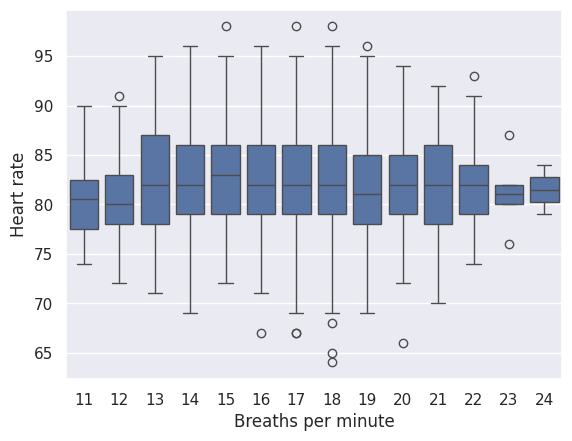

In [243]:
sns.boxplot(x=merged_df['breath_rate'].astype(int), y=merged_df['heart_rate'])
plt.xlabel('Breaths per minute')
plt.ylabel('Heart rate')

Does it seem that there is a correlation between heart rate and breaths per minute? Our null hypothesis in this situation is that heart rates do not increase as breaths per minute increase. Again, as was the case before, we use the Wald test, which addresses exactly this setting.

In [244]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['heart_rate'], merged_df['breath_rate'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -0.0185
Coefficient of determination: 0.00201
p-value: 0.0225


Since the p-value here is smaller than 0.05, we can reject the null hypothesis that the true correlation is zero at the 5% significance level. But again, our data here is synthetically generated and does not necessarily represent the truth.